# Generate Probability of Detection for Operators
Code author: Sahar H. El Abbadi
Date started: 2022-02-23
Date last edited: 2022-03-01

In [1]:
# Setup

# Imports

from plot_methods import plot_detection_limit

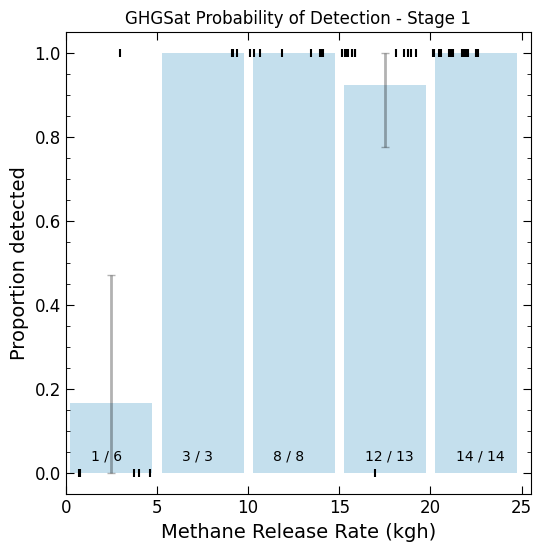

In [2]:
from plot_methods import plot_detection_limit
# GHGSat probability of detection
operator = 'GHGSat'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'km'
n_bins = 5
threshold = 25

plot_detection_limit(operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)

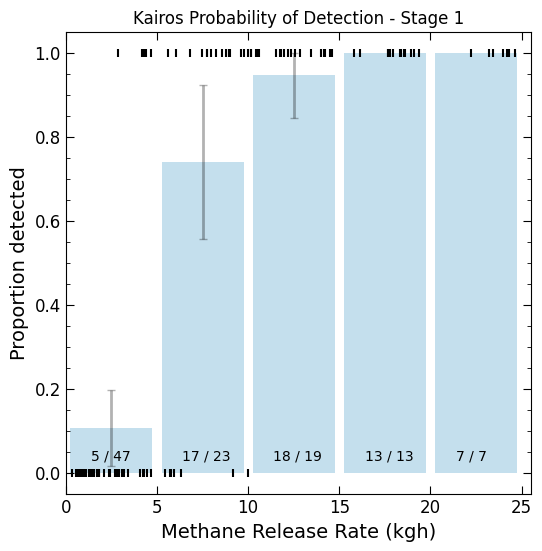

In [4]:
# Kairos probability of detection
operator = 'Kairos'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'km'
n_bins = 5
threshold = 25
plot_detection_limit(operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)


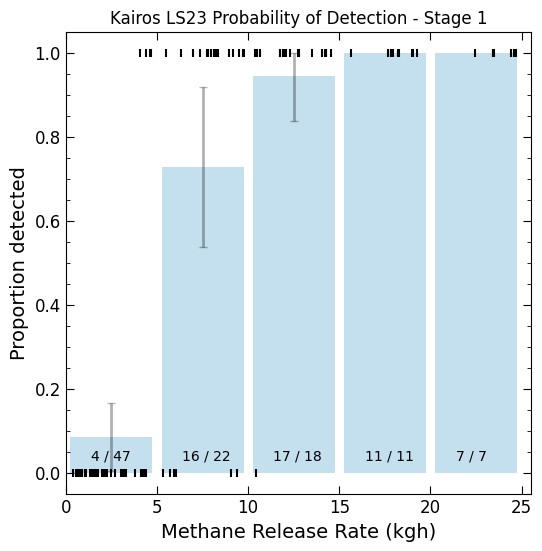

In [5]:
# Kairos probability of detection
operator = 'Kairos LS23'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'km'
n_bins = 5
threshold = 25
plot_detection_limit(operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)

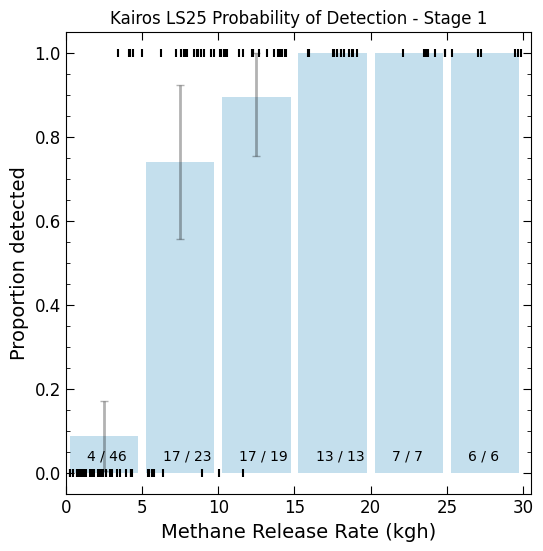

In [2]:
# Kairos probability of detection
operator = 'Kairos LS25'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'km'
n_bins = 6
threshold = 30
plot_detection_limit(operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)

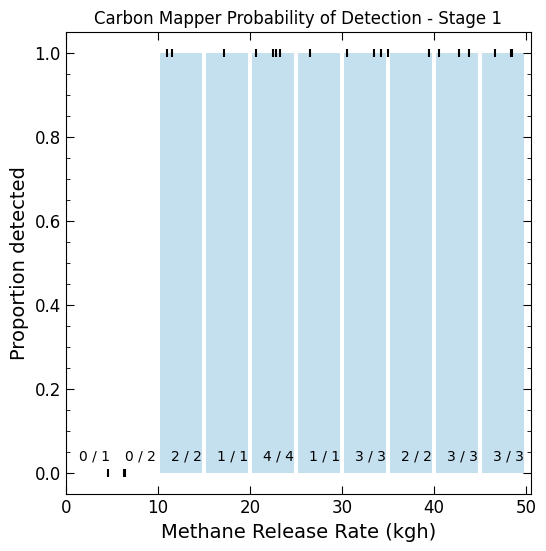

In [5]:
# Carbon Mapper probability of detection
from plot_methods import plot_detection_limit
operator = 'Carbon Mapper'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'km'
n_bins = 10
threshold = 50
plot_detection_limit(operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)

/Users/sea/PycharmProjects/CRF22_Airplanes/plot_methods.py:228: RuntimeWarning: invalid value encountered in scalar divide
  p = binned_data.operator_detected.sum() / binned_data.shape[0]  # df.shape[0] gives number of rows


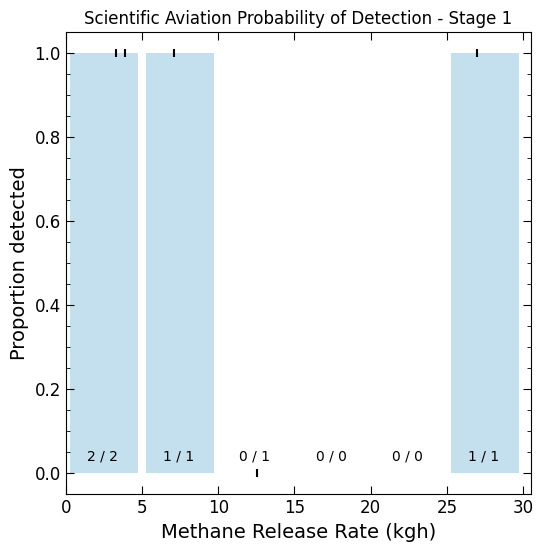

In [6]:
# Scientific Aviation
from plot_methods import plot_detection_limit
# GHGSat probability of detection
operator = 'Scientific Aviation'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'km'
n_bins = 6
threshold = 30

plot_detection_limit(operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)

/Users/sea/PycharmProjects/CRF22_Airplanes/plot_methods.py:221: RuntimeWarning: invalid value encountered in scalar divide
  p = binned_data.operator_detected.sum() / binned_data.shape[0]  # df.shape[0] gives number of rows


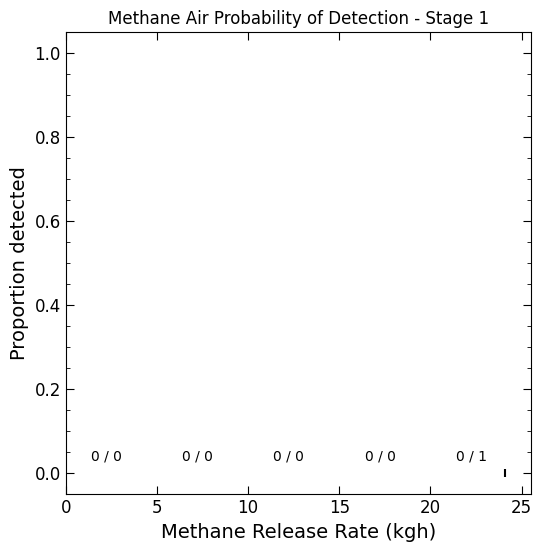

In [7]:
 # Methane Air probability of detection
operator = 'Methane Air'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'km'
n_bins = 5
threshold = 25
plot_detection_limit(operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)

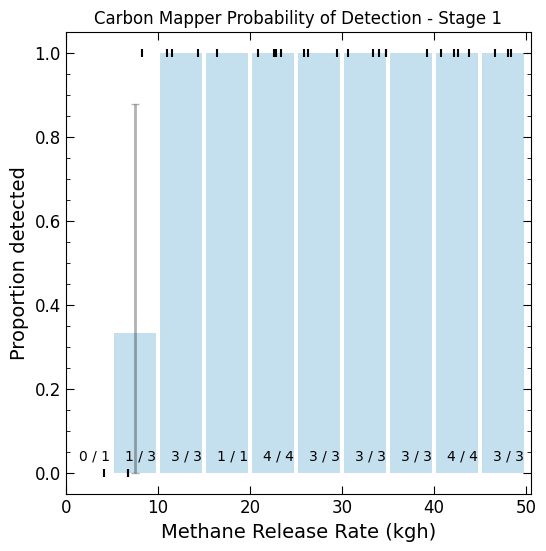

In [4]:
from methods_source import load_overpass_summary, abbreviate_op_name
from plot_methods import rand_jitter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import datetime


# Carbon Mapper: plot that includes ALL their data points regardless of quantification QC

def plot_detection_limit(operator, stage, n_bins, threshold, strict_discard=False, time_ave=60, gas_comp_source='km'):
    # Load overpass summary for operator, stage, and discard criteria:
    operator_df = load_overpass_summary(operator, stage, strict_discard, time_ave, gas_comp_source)

    # Apply QC filter
    # For SI: Carbon Mapper's QC for determining quantification only, and treat their detection column as applied to all points

    if (operator == 'Carbon Mapper') or (operator == 'Scientific Aviation'):
        operator_df = operator_df[(operator_df.stanford_kept == 1)]
    # if (operator == 'Scientific Aviation'):
    #     # Scientific Aviation explicitly stated that all data could be used in determining detection, their QC only
    #     # applied to quantification
    #     operator_df = operator_df[(operator_df.stanford_kept == 1)]
    else:
        operator_df = operator_df[(operator_df.qc_summary == 'pass_all')]

    # Must be non-zero values
    operator_df = operator_df.query('non_zero_release == True')

    # Select release under threshold value
    operator_df = operator_df.query('release_rate_kgh <= @threshold')

    # Create bins for plot
    bins = np.linspace(0, threshold, n_bins + 1)
    detection_probability = np.zeros(n_bins)

    # These variables are for keeping track of values as I iterate through the bins in the for loop below:
    bin_size, bin_num_detected = np.zeros(n_bins).astype('int'), np.zeros(n_bins).astype('int')
    bin_median = np.zeros(n_bins)
    bin_two_sigma = np.zeros(n_bins)
    two_sigma_upper, two_sigma_lower = np.zeros(n_bins), np.zeros(n_bins)

    # For each bin, find number of data points and detection probability

    for i in range(n_bins):

        # Set boundary of bin
        bin_min = bins[i]
        bin_max = bins[i + 1]
        bin_median[i] = (bin_min + bin_max) / 2

        # Select data within the bin range
        binned_data = operator_df.loc[operator_df.release_rate_kgh < bin_max].loc[
            operator_df.release_rate_kgh >= bin_min]

        # Count the total number of overpasses detected within each bin
        bin_num_detected[i] = binned_data.operator_detected.sum()

        n = len(binned_data)
        bin_size[i] = n  # this is the y-value for the bin in the plot
        p = binned_data.operator_detected.sum() / binned_data.shape[0]  # df.shape[0] gives number of rows
        detection_probability[i] = p

        # Standard Deviation of a binomial distribution
        sigma = np.sqrt(p * (1 - p) / n)
        bin_two_sigma[i] = 2 * sigma

        # Find the lower and upper bound defined by two sigma
        two_sigma_lower[i] = 2 * sigma
        two_sigma_upper[i] = 2 * sigma
        if 2 * sigma + p > 1:
            two_sigma_upper[i] = 1 - p  # probability cannot exceed 1
        if p - 2 * sigma < 0:
            two_sigma_lower[i] = p  # if error bar includes zero, set lower bound to p?

    detection_prob = pd.DataFrame({
        "bin_median": bin_median,
        "detection_prob_mean": detection_probability,
        "detection_prob_two_sigma_upper": two_sigma_upper,
        "detection_prob_two_sigma_lower": two_sigma_lower,
        "n_data_points": bin_size,
        "n_detected": bin_num_detected})

    # Function will output cm_detection and detection_prob

    detection_plot = detection_prob.copy()
    fig, ax = plt.subplots(1, figsize=(6, 6))

    # Set bin width:
    w = threshold / n_bins / 2.5

    # Use n_bins set above
    for i in range(n_bins):
        ax.annotate(f'{detection_plot.n_detected[i]} / {detection_plot.n_data_points[i]}',
                    [detection_plot.bin_median[i] - w / 1.8, 0.03], fontsize=10)

    # for plotting purpose, we don't want a small hyphen indicating zero uncertainty interval
    detection_plot.loc[detection_plot['detection_prob_two_sigma_lower'] == 0, 'detection_prob_two_sigma_lower'] = np.nan
    detection_plot.loc[detection_plot.detection_prob_two_sigma_upper == 0, 'detection_prob_two_sigma_upper'] = np.nan
    detection_plot.loc[detection_plot.detection_prob_mean == 0, 'detection_prob_mean'] = np.nan

    # To avoid RuntimeWarning: All-NaN axis encountered, set yerr to None if all values are np.nan in sigma values
    # (this is the case for Carbon Mapper)

    sigma_lower = detection_plot.detection_prob_two_sigma_lower
    sigma_upper = detection_plot.detection_prob_two_sigma_upper

    if sigma_lower.isnull().all() or sigma_upper.isnull().all():
        y_error = None
    else:
        y_error = [sigma_lower, sigma_upper]

    # Plot bars and detection points
    ax.bar(detection_plot.bin_median,
           detection_plot.detection_prob_mean,
           # yerr=[detection_plot.detection_prob_two_sigma_lower, detection_plot.detection_prob_two_sigma_upper],
           yerr=y_error,
           error_kw=dict(lw=2, capsize=3, capthick=1, alpha=0.3),
           width=threshold / n_bins - 0.5, alpha=0.6, color='#9ecae1', ecolor='black', capsize=2)

    # yulia's color: edgecolor="black",facecolors='none'
    x_data = rand_jitter(operator_df.release_rate_kgh)

    ax.scatter(x_data, np.multiply(operator_df.operator_detected, 1),
               facecolors='black',
               marker='|')

    # Add more room on top and bottom
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([0, threshold + 0.5])

    # Axes formatting and labels
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=11)
    ax.set_xlabel('Methane Release Rate (kgh)', fontsize=14)
    ax.set_ylabel('Proportion detected', fontsize=14)
    ax.tick_params(direction='in', right=True, top=True)
    ax.tick_params(labelsize=12)
    ax.minorticks_on()
    ax.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
    ax.tick_params(direction='in', which='minor', length=3, bottom=False, top=False, left=True, right=True)
    ax.tick_params(direction='in', which='major', length=6, bottom=True, top=True, left=True, right=True)

    # Set axes and background color to white
    ax.set_facecolor('white')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')

    plt.title(f'{operator} Probability of Detection - Stage {stage}')

    # Save figure

    if strict_discard == True:
        discard = 'strict'
    else:
        discard = 'lax'

    now = datetime.datetime.now()
    save_time = now.strftime("%Y%m%d")
    op_ab = abbreviate_op_name(operator)
    fig_name = f'detect_limit_{op_ab}_stage{stage}_{discard}_{save_time}'
    fig_path = pathlib.PurePath('04_figures', '00_presentation_figs', fig_name)
    plt.savefig(fig_path)
    plt.show()

    # Save data used to make plots
    # operator_df.to_csv(pathlib.PurePath('03_results', 'detect_probability_data',
    #                                     f'{op_ab}_{stage}_detect_{save_time}.csv'))
    # detection_prob.to_csv(pathlib.PurePath('03_results', 'detect_probability_data',
    #                                        f'{op_ab}_{stage}_{threshold}kgh_{n_bins}bins_{save_time}.csv'))
    return


plot_detection_limit('Carbon Mapper', stage=1, n_bins=10, threshold=50)

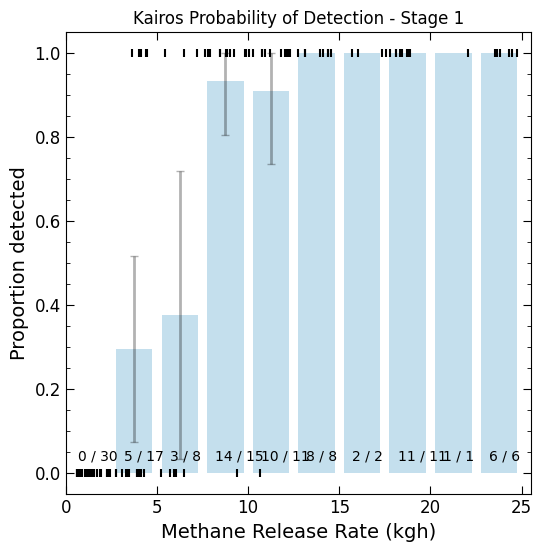

In [2]:
from plot_methods import plot_detection_limit
operator = 'Kairos'
stage = 1
strict_discard = False
time_ave = 60
gas_comp_source = 'km'
n_bins = 10
threshold = 25
plot_detection_limit(operator=operator, stage=stage, n_bins=n_bins,threshold=threshold, strict_discard=strict_discard, time_ave=time_ave, gas_comp_source=gas_comp_source)